In [10]:
import os
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
import sionna as sn
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Layer
import pickle

In [11]:
gpus = tf.config.list_physical_devices("GPU")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '3'

if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

tf.get_logger().setLevel("ERROR")
%matplotlib inline
sn.config.seed = 42

In [16]:
# QAM end to end system
binary_source = sn.utils.BinarySource()
NUM_BITS_PER_SYMBOL = 6
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL, trainable=True)

mapper = sn.mapping.Mapper(constellation=constellation)
demapper = sn.mapping.Demapper("app", constellation=constellation)

awgn_channel = sn.channel.AWGN()


In [20]:
BATCH_SIZE = 128

EBNO_db = 17.0

no = sn.utils.ebnodb2no(ebno_db=EBNO_db,
                     num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                     coderate=1.0)

bits = binary_source([BATCH_SIZE,
                     1200])
x = mapper(bits)

y = awgn_channel([x, no])

llr = demapper([y, no])

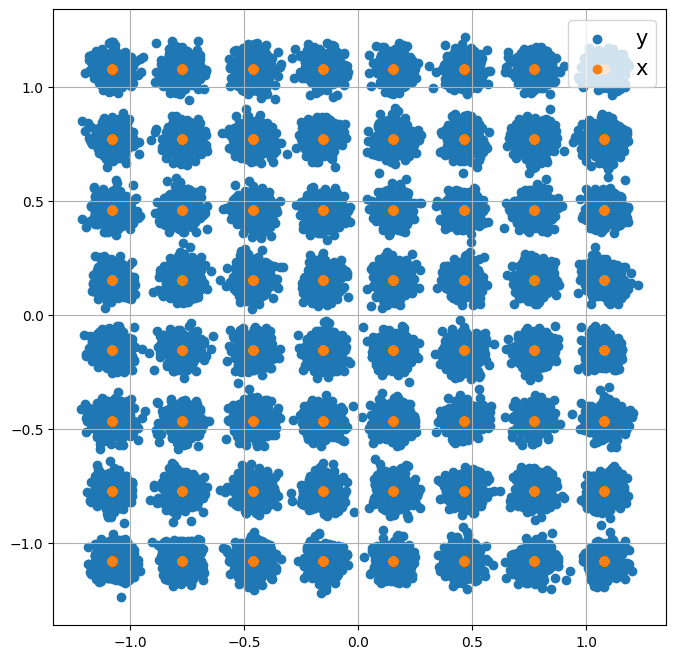

In [22]:
plt.figure(figsize=(8, 8))
plt.axes().set_aspect(1.0)
plt.grid(True)
plt.scatter(tf.math.real(y), tf.math.imag(y), label="y")
plt.scatter(tf.math.real(x), tf.math.imag(x), label="x")
plt.legend(fontsize=15);

In [28]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

print(f"BCE: {bce(bits, llr)}")

BCE: 0.00012394246004987508


In [30]:
with tf.GradientTape() as tape:
    bits = binary_source([BATCH_SIZE, 1200])
    x = mapper(bits)
    y = awgn_channel([x, no])
    llr = demapper([y, no])
    loss = bce(bits, llr)

In [32]:
gradient = tape.gradient(loss, tape.watched_variables())

In [33]:
for g in gradient:
    print(g.shape)

(2, 64)


In [35]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)

In [37]:
optimizer.apply_gradients(zip(gradient, tape.watched_variables()))

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

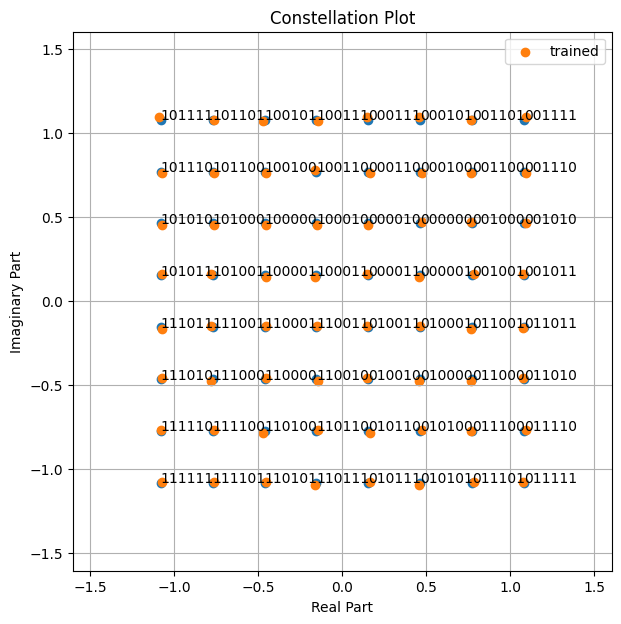

In [45]:
fig = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL).show()
fig.axes[0].scatter(tf.math.real(constellation.points), tf.math.imag(constellation.points), label="trained")
fig.axes[0].legend();

In [49]:
class NeuralDemapper(Layer): # Inherits from Keras Layer

    def __init__(self):
        super().__init__()

        # The three dense layers that form the custom trainable neural network-based demapper
        self.dense_1 = Dense(64, 'relu')
        self.dense_2 = Dense(64, 'relu')
        self.dense_3 = Dense(NUM_BITS_PER_SYMBOL, None) # The last layer has no activation and therefore outputs logits, i.e., LLRs

    def call(self, y):

        # y : complex-valued with shape [batch size, block length]
        # y is first mapped to a real-valued tensor with shape
        #  [batch size, block length, 2]
        # where the last dimension consists of the real and imaginary components
        # The dense layers operate on the last dimension, and treat the inner dimensions as batch dimensions, i.e.,
        # all the received symbols are independently processed.
        nn_input = tf.stack([tf.math.real(y), tf.math.imag(y)], axis=-1)
        z = self.dense_1(nn_input)
        z = self.dense_2(z)
        z = self.dense_3(z) # [batch size, number of symbols per block, number of bits per symbol]
        llr = tf.reshape(z, [tf.shape(y)[0], -1]) # [batch size, number of bits per block]
        return llr

In [64]:
class End2EndSystem(Model): # Inherits from Keras Model

    def __init__(self, training):

        super().__init__() # Must call the Keras model initializer

        self.constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL, trainable=True) # Constellation is trainable
        self.mapper = sn.mapping.Mapper(constellation=self.constellation)
        self.demapper = NeuralDemapper() # Intantiate the NeuralDemapper custom layer as any other
        self.binary_source = sn.utils.BinarySource()
        self.awgn_channel = sn.channel.AWGN()
        self.bce = tf.keras.losses.BinaryCrossentropy(from_logits=True) # Loss function

        self.training = training

    @tf.function() # Enable graph execution to speed things up
    def __call__(self, batch_size, ebno_db):

        # no channel coding used; we set coderate=1.0
        no = sn.utils.ebnodb2no(ebno_db,
                                num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                                coderate=1.0)
        bits = self.binary_source([batch_size, 1200]) # Blocklength set to 1200 bits
        x = self.mapper(bits)
        y = self.awgn_channel([x, no])
        llr = self.demapper(y)  # Call the NeuralDemapper custom layer as any other
        if self.training:
            loss = self.bce(bits, llr)
            return loss
        else:
            return bits, llr

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     10.0 | 2.6966e-02 | 1.0000e+00 |        4142 |      153600 |          128 |         128 |         0.4 |reached target block errors
   10.526 | 2.1074e-02 | 1.0000e+00 |        3237 |      153600 |          128 |         128 |         0.1 |reached target block errors
   11.053 | 1.6458e-02 | 1.0000e+00 |        2528 |      153600 |          128 |         128 |         0.1 |reached target block errors
   11.579 | 1.2812e-02 | 1.0000e+00 |        1968 |      153600 |          128 |         128 |         0.1 |reached target block errors
   12.105 | 8.7370e-03 | 1.0000e+00 |        1342 |      153600 |          128 |         128 |         0.1 |reached target block errors
   12.632 | 6.0938e-03 | 1.0000e+00 |         936 |      153600 |

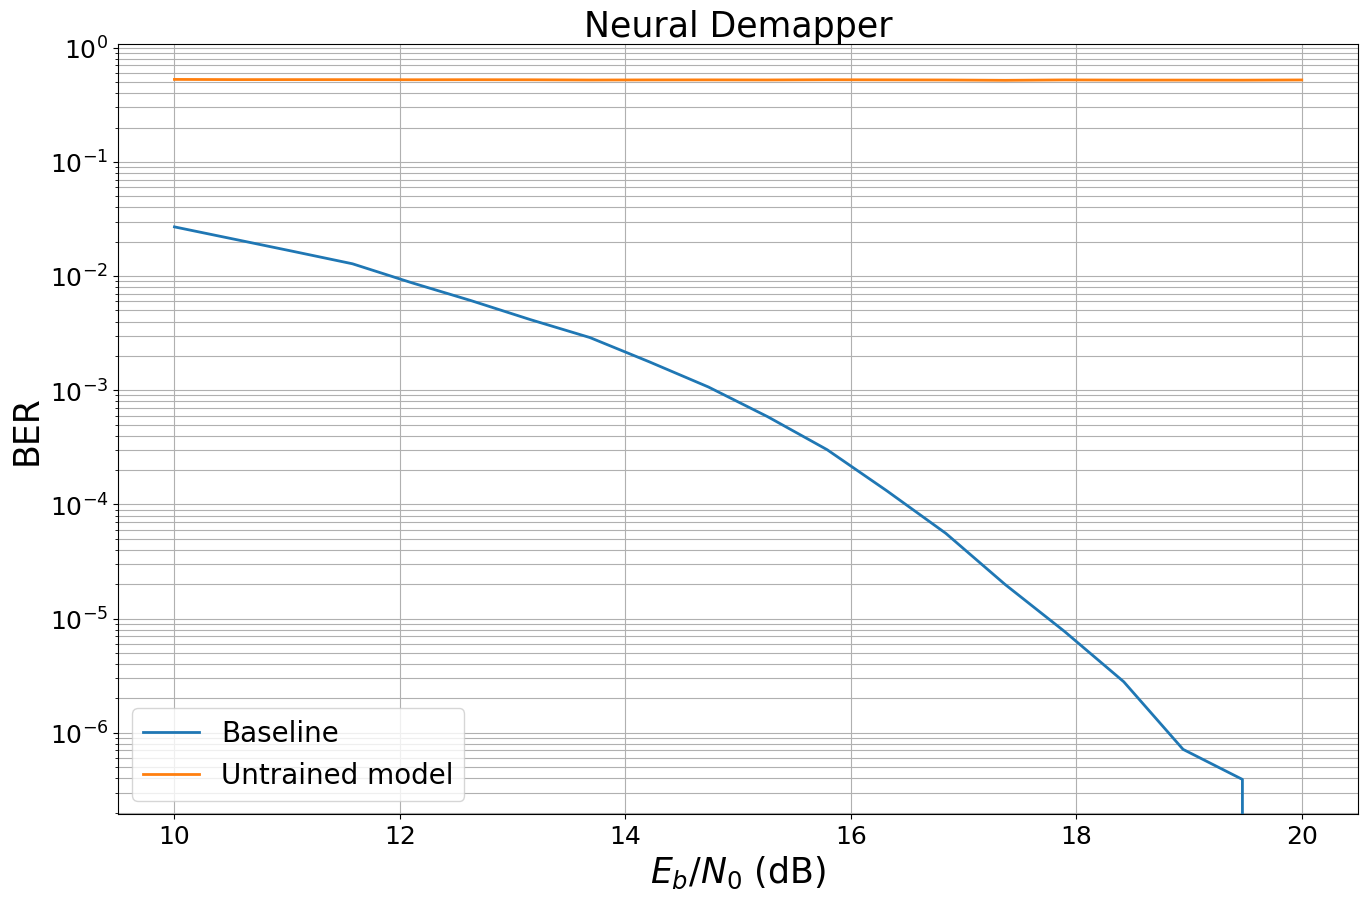

In [65]:
EBN0_DB_MIN = 10.0
EBN0_DB_MAX = 20.0


###############################
# Baseline
###############################

class Baseline(Model): # Inherits from Keras Model

    def __init__(self):

        super().__init__() # Must call the Keras model initializer

        self.constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
        self.mapper = sn.mapping.Mapper(constellation=self.constellation)
        self.demapper = sn.mapping.Demapper("app", constellation=self.constellation)
        self.binary_source = sn.utils.BinarySource()
        self.awgn_channel = sn.channel.AWGN()

    @tf.function # Enable graph execution to speed things up
    def __call__(self, batch_size, ebno_db):

        # no channel coding used; we set coderate=1.0
        no = sn.utils.ebnodb2no(ebno_db,
                                num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                                coderate=1.0)
        bits = self.binary_source([batch_size, 1200]) # Blocklength set to 1200 bits
        x = self.mapper(bits)
        y = self.awgn_channel([x, no])
        llr = self.demapper([y,no])
        return bits, llr

###############################
# Benchmarking
###############################

baseline = Baseline()
model = End2EndSystem(False)
ber_plots = sn.utils.PlotBER("Neural Demapper")
ber_plots.simulate(baseline,
                  ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20),
                  batch_size=BATCH_SIZE,
                  num_target_block_errors=100, # simulate until 100 block errors occured
                  legend="Baseline",
                  soft_estimates=True,
                  max_mc_iter=100, # run 100 Monte-Carlo simulations (each with batch_size samples)
                  show_fig=False);
ber_plots.simulate(model,
                  ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20),
                  batch_size=BATCH_SIZE,
                  num_target_block_errors=100, # simulate until 100 block errors occured
                  legend="Untrained model",
                  soft_estimates=True,
                  max_mc_iter=100, # run 100 Monte-Carlo simulations (each with batch_size samples)
                  show_fig=True);

In [66]:
# Number of iterations used for training
NUM_TRAINING_ITERATIONS = 30000

# Set a seed for reproducibility
tf.random.set_seed(1)

# Instantiating the end-to-end model for training
model_train = End2EndSystem(training=True)

# Adam optimizer (SGD variant)
optimizer = tf.keras.optimizers.Adam()

# Training loop
for i in range(NUM_TRAINING_ITERATIONS):
    # Forward pass
    with tf.GradientTape() as tape:
        loss = model_train(BATCH_SIZE, 15.0) # The model is assumed to return the BMD rate
    # Computing and applying gradients
    grads = tape.gradient(loss, model_train.trainable_weights)
    optimizer.apply_gradients(zip(grads, model_train.trainable_weights))
    # Print progress
    if i % 100 == 0:
        print(f"{i}/{NUM_TRAINING_ITERATIONS}  Loss: {loss:.2E}", end="\r")

In [67]:
# Save the weightsin a file
weights = model_train.get_weights()
with open('weights-neural-demapper', 'wb') as f:
    pickle.dump(weights, f)

In [68]:
# Instantiating the end-to-end model for evaluation
model = End2EndSystem(training=False)
# Run one inference to build the layers and loading the weights
model(tf.constant(1, tf.int32), tf.constant(10.0, tf.float32))
with open('weights-neural-demapper', 'rb') as f:
    weights = pickle.load(f)
    model.set_weights(weights)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     10.0 | 2.7507e-02 | 1.0000e+00 |        4225 |      153600 |          128 |         128 |         0.2 |reached target block errors
   10.526 | 2.1986e-02 | 1.0000e+00 |        3377 |      153600 |          128 |         128 |         0.0 |reached target block errors
   11.053 | 1.6211e-02 | 1.0000e+00 |        2490 |      153600 |          128 |         128 |         0.0 |reached target block errors
   11.579 | 1.2422e-02 | 1.0000e+00 |        1908 |      153600 |          128 |         128 |         0.0 |reached target block errors
   12.105 | 9.5117e-03 | 1.0000e+00 |        1461 |      153600 |          128 |         128 |         0.0 |reached target block errors
   12.632 | 6.3411e-03 | 1.0000e+00 |         974 |      153600 |

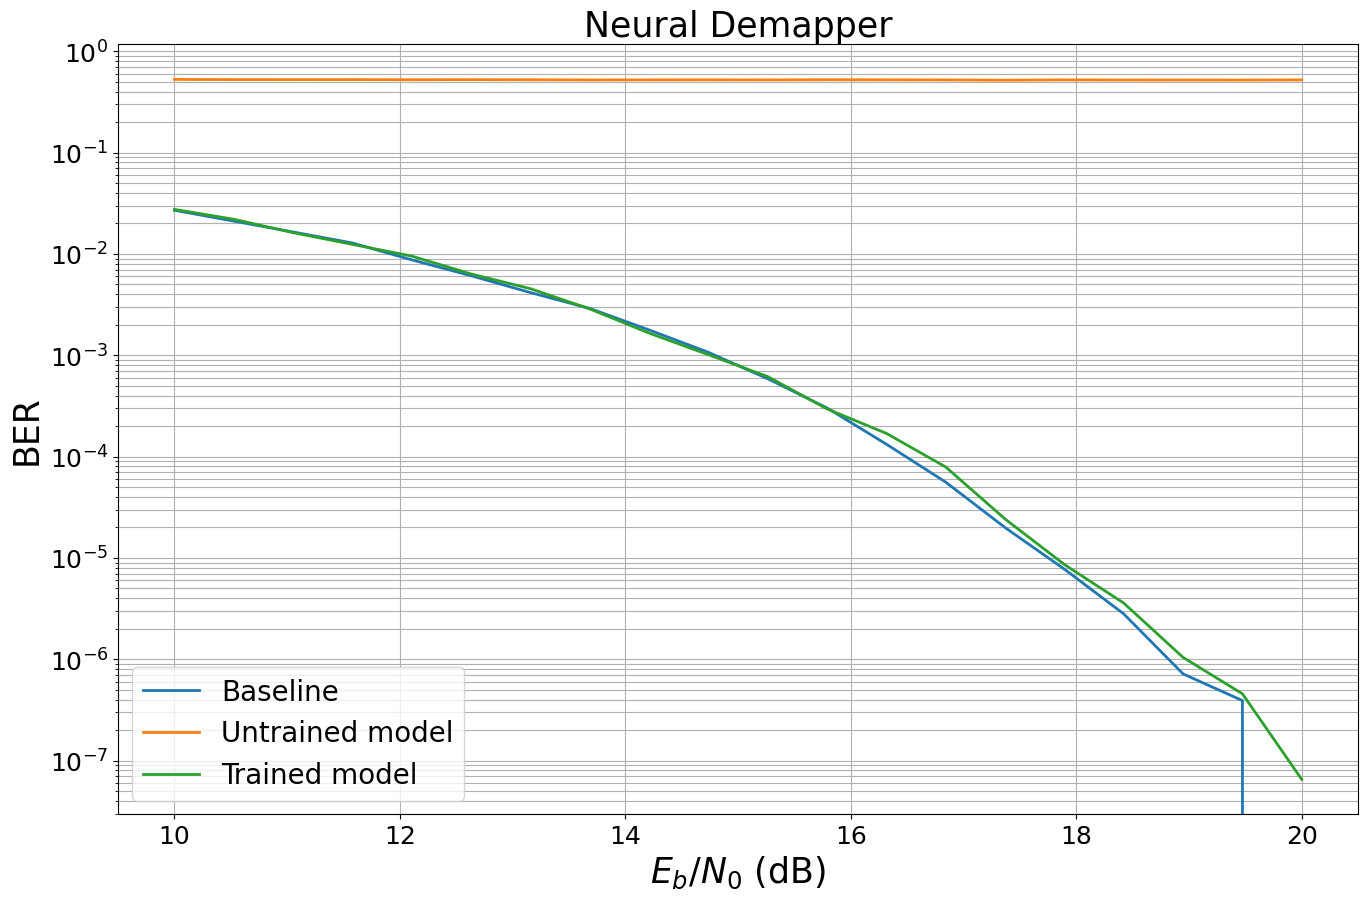

In [69]:
# Computing and plotting BER
ber_plots.simulate(model,
                  ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20),
                  batch_size=BATCH_SIZE,
                  num_target_block_errors=100,
                  legend="Trained model",
                  soft_estimates=True,
                  max_mc_iter=100,
                  show_fig=True);